In [1]:
# import library 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transaction_exploration import graphical_analysis
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from datetime import timedelta

In [76]:
# read of transaction data
path = '/Users/lucariotto/Documents/Personal/Gestione denaro/Analisi spese/Gestione entrate-spese.xlsx'
transaction_df = pd.read_excel(path, sheet_name='Transazioni')

In [77]:
# associations between catecories and subcategories
categories_associations = {
    "Casa": ["Affitto", "Bollette", "Pulizia", np.nan],
    "Spesa": [np.nan],
    "Viaggi/Esperienze": [np.nan],
    "Trasporti": ["Benzina", "Mezzi pubblici", "Mezzi a noleggio", "Autostrada", np.nan],
    "Serate": ["Alcool", "Entrate/Biglietti", np.nan],
    "Pasti fuori": ["Cene", "Pranzi", "Pranzi lavoro", np.nan],
    "Sport": ["Pass", "Attrezzatura", np.nan],
    "Abbonamenti": [np.nan],
    "Shopping": [np.nan],
    "Stipendio": [np.nan],
    "Altre entrate": [np.nan],
    "Giroconto entrata": [np.nan],
    "Giroconto uscita": [np.nan],
    "Altro": [np.nan]
}
# keep only the important column
cols_to_keep = [
    "DATA",
    "GIORNO",
    "MESE",
    "ANNO",
    "TIPO TRANSAZIONE",
    "CONTO",
    "CATEGORIA",
    "SOTTOCATEGORIA",
    "IMPORTO"
]
category_df = transaction_df.loc[transaction_df['CATEGORIE'].notna(), 'CATEGORIE']
transaction_df = transaction_df[cols_to_keep]

In [78]:
transaction_df.loc[:,'mese_anno'] = transaction_df['DATA'].dt.to_period('M')
mese_anno_df = pd.DataFrame(transaction_df['mese_anno'].unique(), columns=['mese_anno'])
subcat_df = pd.DataFrame(columns=['CATEGORIA', 'SOTTOCATEGORIA'])
for key in categories_associations:
    cat = [key] * len(categories_associations[key])
    subcat_df = pd.concat([subcat_df, pd.DataFrame({'CATEGORIA': cat, 
                                                   'SOTTOCATEGORIA' : categories_associations[key]})],
                                                     axis=0)
df_outer_join = pd.merge(
    mese_anno_df,  # seleziona solo la colonna 'mese_anno'
    category_df,  # seleziona solo la colonna 'categoria'
    how='cross',  # tipo di join (outer per includere tutte le combinazioni)
    on=None,  # nessuna colonna su cui fare l'unione
)
df_outer_join.rename(columns={'CATEGORIE': 'CATEGORIA'}, inplace=True)
df_outer_join = pd.merge(
    df_outer_join,
    subcat_df,
    on='CATEGORIA',
    how='left'
)
transaction_df = pd.merge(
    df_outer_join,
    transaction_df,
    how='left',
    on=['mese_anno', 'CATEGORIA', 'SOTTOCATEGORIA']
)

transaction_df['IMPORTO'] = np.where(transaction_df['IMPORTO'].isna(), 0, transaction_df['IMPORTO'])

# fill some na column
exit_category = [
    "Casa",
    "Spesa",
    "Viaggi/Esperienze",
    "Trasporti",
    "Serate",
    "Pasti fuori",
    "Sport",
    "Abbonamenti",
    "Shopping",
    "Altro"
]
transaction_df['TIPO TRANSAZIONE'] = np.where(transaction_df['CATEGORIA'].isin(exit_category), 'Uscita', 'Entrata')


In [162]:
gplot = graphical_analysis(transaction_df)
pp = gplot.montly_ma_plot(column_name='IMPORTO', window=10, category='Trasporti', category_column='CATEGORIA')
pio.renderers.default = "browser"
pp.show()

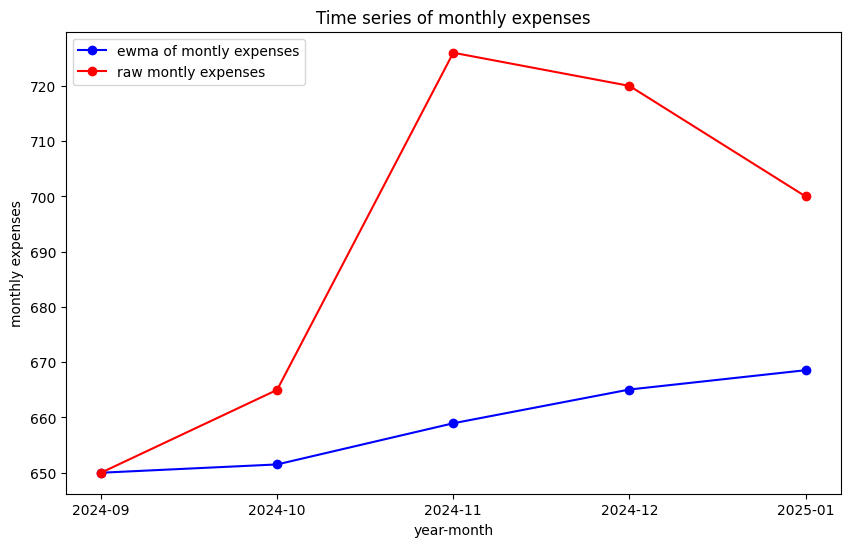

In [144]:
# Analysis of monthly outgoing transactions
monthly_transaction = transaction_df[transaction_df['TIPO TRANSAZIONE'] == 'Uscita']
#monthly_transaction = monthly_transaction[monthly_transaction['CATEGORIA']=='Viaggi/Esperienze']
#monthly_transaction.loc[:,'mese_anno'] = monthly_transaction['DATA'].dt.to_period('M')
monthly_transaction = monthly_transaction.groupby(['mese_anno', 'CATEGORIA'])[['IMPORTO']].sum().reset_index()
monthly_transaction = monthly_transaction[monthly_transaction['CATEGORIA']=='Casa']
monthly_transaction['mese_anno'] = monthly_transaction['mese_anno'].astype('str')
monthly_transaction['importo_ewma_05'] = monthly_transaction['IMPORTO'].ewm(alpha=0.1, adjust=False).mean()

#Creare il grafico
plt.figure(figsize=(10, 6))  # Impostare le dimensioni del grafico
plt.plot(monthly_transaction["mese_anno"], monthly_transaction["importo_ewma_05"], 
         marker="o", linestyle="-", color="b", label='ewma of montly expenses')
plt.plot(monthly_transaction["mese_anno"], monthly_transaction["IMPORTO"], 
         marker="o", linestyle="-", color="r", label='raw montly expenses')
plt.xlabel("year-month")
plt.ylabel("monthly expenses")
plt.title("Time series of monthly expenses")
plt.legend(loc='best')




In [119]:
print(transaction_df.columns)
category_expenses = (transaction_df[transaction_df['TIPO TRANSAZIONE'] == 'Uscita']
                     .groupby(['mese_anno', 'CATEGORIA'])['IMPORTO']
                     .sum().reset_index())
category_expenses = (category_expenses.groupby('CATEGORIA')['IMPORTO']
                            .rolling(window=10, min_periods=1).mean().reset_index())
category_expenses = (category_expenses.groupby('CATEGORIA')
               .last().drop(['level_1'], axis=1))
print(category_expenses)

Index(['mese_anno', 'CATEGORIA', 'DATA', 'GIORNO', 'MESE', 'ANNO',
       'TIPO TRANSAZIONE', 'CONTO', 'SOTTOCATEGORIA', 'IMPORTO'],
      dtype='object')
                   IMPORTO
CATEGORIA                 
Abbonamenti            0.0
Altro                  6.0
Casa                 692.2
Pasti fuori          111.4
Serate               113.4
Shopping              65.0
Spesa                 64.2
Sport                  4.0
Trasporti             88.8
Viaggi/Esperienze     27.2


In [ ]:

year_month = (
    transaction_df
    .sort_values(by = 'mese_anno', ascending = False)['mese_anno']
    .astype('str')
    .unique())
year_month = list(year_month[:3]) + ['mean']
print(year_month)

['2025-01', '2024-12', '2024-11', 'mean']


In [187]:
year_month = (
    transaction_df
    .sort_values(by = 'mese_anno', ascending = False)['mese_anno']
    .astype('str')
    .unique()
    )
year_month = list(year_month[:3]) + ['Mooving average']
print(year_month)
income_df = (
    transaction_df[(transaction_df['TIPO TRANSAZIONE']=='Entrata') & (transaction_df['mese_anno']=='2024-11')]
    .groupby('CATEGORIA')[['IMPORTO']]
    .sum()
)
income_df.reset_index(inplace=True)
print(income_df)
fig = go.Figure(
    data=[
        go.Pie(
            labels=income_df['CATEGORIA'],        # Labels (categories)
            values=income_df['IMPORTO'],           # Values
            hoverinfo='label+percent+value', # Show label, percentage, and value on hover
            textinfo='percent',           # Display only percentage on the pie chart
            #marker=dict(colors=['#636EFA', '#EF553B', '#00CC96', '#AB63FA']),  # Custom colors
        )
    ]
)
    # Update layout to include a legend
fig.update_layout(
    title="Income Category Distribution",
    legend=dict(title="Categories", orientation="v", x=1, y=1),
)
        

['2025-01', '2024-12', '2024-11', 'Mooving average']
           CATEGORIA  IMPORTO
0      Altre entrate      0.0
1  Giroconto entrata      0.0
2   Giroconto uscita      0.0
3          Stipendio    800.0


In [50]:
assets_df = pd.read_excel(path, sheet_name='Patrimonio')
print(assets_df)
print(assets_df.dtypes)

        DATA CONTO TIPO CONTO     ASSET CLASS NOME ASSET    TICKER  QUANTITA
0 2024-10-31   yyy        yyy  Conto corrente  liquidita       NaN         5
1 2024-10-31   xxx        xxx       Azionario        ETF      ACWX         2
2 2024-11-30   xxx        xxx       Azionario        ETF      ACWX         4
3 2024-11-30   yyy        yyy  Conto corrente  liquidita  CSSPX.MI        10
DATA           datetime64[ns]
CONTO                  object
TIPO CONTO             object
ASSET CLASS            object
NOME ASSET             object
TICKER                 object
QUANTITA                int64
dtype: object


In [109]:
min_date = assets_df['DATA'].min()
max_date = assets_df['DATA'].max()

date_seq = pd.DataFrame({'DATA' : pd.date_range(start=min_date, end=max_date, freq='D')})
dates = list(assets_df['DATA'].unique()) + [pd.Timestamp.now()]
asset_df_exp = pd.DataFrame(columns=assets_df.columns)
for i in range(0, len(dates)-1):
    dt_corr = dates[i]
    dates_sup = dates[i+1] - pd.Timedelta(days=1)
    date_seq = pd.DataFrame({'DATA' : pd.date_range(start=dt_corr, end=dates_sup, freq='D')})
    assets_date_cor = (
        date_seq
        .merge(
            assets_df[assets_df['DATA']==dt_corr],
            how = 'cross'
        )
    )
    asset_df_exp = pd.concat([asset_df_exp, assets_date_cor], axis=0)

print(asset_df_exp)


    DATA CONTO TIPO CONTO     ASSET CLASS NOME ASSET    TICKER QUANTITA  \
0    NaN   yyy        yyy  Conto corrente  liquidita       NaN        5   
1    NaN   xxx        xxx       Azionario        ETF      ACWX        2   
2    NaN   yyy        yyy  Conto corrente  liquidita       NaN        5   
3    NaN   xxx        xxx       Azionario        ETF      ACWX        2   
4    NaN   yyy        yyy  Conto corrente  liquidita       NaN        5   
..   ...   ...        ...             ...        ...       ...      ...   
97   NaN   yyy        yyy  Conto corrente  liquidita  CSSPX.MI       10   
98   NaN   xxx        xxx       Azionario        ETF      ACWX        4   
99   NaN   yyy        yyy  Conto corrente  liquidita  CSSPX.MI       10   
100  NaN   xxx        xxx       Azionario        ETF      ACWX        4   
101  NaN   yyy        yyy  Conto corrente  liquidita  CSSPX.MI       10   

        DATA_x     DATA_y  
0   2024-10-31 2024-10-31  
1   2024-10-31 2024-10-31  
2   2024-11-01 

In [110]:
from get_financial_data import get_historical_data

In [111]:
ticker = assets_df.dropna(subset=['TICKER'])['TICKER'].unique().tolist()
fin_df = get_historical_data(ticker, '2019-01-01', pd.Timestamp.now())
print(fin_df.tail())


Price           Close                   High                    Low  \
Ticker           ACWX    CSSPX.MI       ACWX    CSSPX.MI       ACWX   
Date                                                                  
2025-01-14  51.700001  601.200012  51.770000  607.440002  51.450001   
2025-01-15  52.310001  611.729980  52.389999  612.109985  52.119999   
2025-01-16  52.459999  612.549988  52.660000  616.059998  52.320000   
2025-01-17  52.740002  618.669983  53.029999  619.659973  52.630001   
2025-01-20        NaN  614.409973        NaN  618.140015        NaN   

Price                        Open                 Volume           
Ticker        CSSPX.MI       ACWX    CSSPX.MI       ACWX CSSPX.MI  
Date                                                               
2025-01-14  600.400024  51.689999  606.250000   917600.0   5768.0  
2025-01-15  601.200012  52.240002  601.369995  1756500.0   5798.0  
2025-01-16  612.000000  52.500000  615.840027  2830200.0  11054.0  
2025-01-17  613.000000 

In [112]:
asset_df_exp = (
    asset_df_exp
    .drop(columns=['DATA', 'DATA_y'])
    .rename(columns={'DATA_x' : 'DATA'})
)
dta_df = pd.DataFrame({'DATA' : asset_df_exp["DATA"].unique()})
fin_df = (
    dta_df
    .merge(
        fin_df['Close']
        .reset_index()
        .rename(columns={'Date' : 'DATA'}),
        on='DATA',
        how='left')
)
fin_df[ticker] = fin_df[ticker].apply(lambda col: col.fillna(method='ffill'))

/var/folders/gm/f4w23dqd2qx0rrtf8py4b0ww0000gn/T/ipykernel_35198/61384875.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  fin_df[ticker] = fin_df[ticker].apply(lambda col: col.fillna(method='ffill'))


In [113]:

fin_data = (
    fin_df
    .drop(columns=['DATA'])
    .sort_index(axis=1)
    .values
)
max_length = len(ticker)
quantity_df = (
    asset_df_exp[asset_df_exp['TICKER'].isin(ticker)]
    .sort_values(by=['DATA', 'TICKER'])
    .groupby('DATA')
    .agg({'QUANTITA': list})['QUANTITA']
    .apply(lambda x: x + [0] * (max_length - len(x)))
)
value_df = pd.DataFrame({
    'DATA' : dta_df['DATA'],
    'value' : np.diag(fin_data @ np.array(quantity_df.tolist()).T)}
)

In [114]:
asset_df_exp = (
    asset_df_exp[asset_df_exp['TICKER'].isna()]
    .groupby('DATA')['QUANTITA']
    .sum()
    .reset_index()
    .merge(value_df, on = 'DATA', how = 'inner')
    .assign(curval=lambda x: x['value']+x['QUANTITA'])
    .drop(columns=['value', 'QUANTITA'])
)


In [120]:
min_date = min(asset_df_exp['DATA'])
asset_init = asset_df_exp[asset_df_exp['DATA'] == min_date]['curval'].values
cashflow_df = (
    dta_df
    .merge(
        (transaction_df
        .pivot_table(values='IMPORTO', index='DATA', columns='TIPO TRANSAZIONE', aggfunc='sum')
        .reset_index()
        .loc[lambda df: df['DATA'] >= min_date]
        .fillna(0)
        .assign(cashflow=lambda x: x['Entrata']-x['Uscita'])),
        on='DATA',
        how='left'
    )
    .sort_values('DATA')
    .apply(lambda col: col.fillna(0) if col.name =='cashflow' else col)
)
cashflow_df.loc[cashflow_df['DATA'] == min_date, 'cashflow'] +=  asset_init
cashflow_df['cashflow'] = cashflow_df['cashflow'].cumsum()


/var/folders/gm/f4w23dqd2qx0rrtf8py4b0ww0000gn/T/ipykernel_35198/3864791742.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-45.41850280761719]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  cashflow_df.loc[cashflow_df['DATA'] == min_date, 'cashflow'] +=  asset_init


         DATA CONTO TIPO CONTO     ASSET CLASS NOME ASSET TICKER  QUANTITA
0  2024-10-31   yyy        yyy  Conto corrente  liquidita    NaN       5.0
1  2024-10-31   xxx        xxx       Azionario        ETF   ACWX       2.0
2  2024-11-01   NaN        NaN             NaN        NaN    NaN       NaN
3  2024-11-02   NaN        NaN             NaN        NaN    NaN       NaN
4  2024-11-03   NaN        NaN             NaN        NaN    NaN       NaN
..        ...   ...        ...             ...        ...    ...       ...
47 2025-01-15   NaN        NaN             NaN        NaN    NaN       NaN
48 2025-01-16   NaN        NaN             NaN        NaN    NaN       NaN
49 2025-01-17   NaN        NaN             NaN        NaN    NaN       NaN
50 2025-01-18   NaN        NaN             NaN        NaN    NaN       NaN
51 2025-01-19   NaN        NaN             NaN        NaN    NaN       NaN

[83 rows x 7 columns]


/var/folders/gm/f4w23dqd2qx0rrtf8py4b0ww0000gn/T/ipykernel_35198/2421217244.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  asset_df_exp = pd.concat([asset_df_exp, assets_date_cor], axis=0)
